In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import os
import tensorflow as tf

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
print(tf.__version__)
tf.keras.backend.clear_session()


def create_time_steps(length):
    return list(range(-length, 0))


def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)


def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()


def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()



2.0.0


realDate      object
Date           int64
Adj_Close    float64
Adj_Won      float64
Open         float64
High         float64
Low          float64
Volume       float64
dtype: object
     realDate      Date  Adj_Close  Adj_Won    Open    High     Low    Volume
0  2002.01.08  20020108     5000.0      0.0  5000.0  5000.0  5000.0  174230.0
1  2002.01.09  20020109     5400.0    400.0  5050.0  5550.0  4820.0  825422.0
2  2002.01.10  20020110     4800.0   -600.0  5400.0  5430.0  4760.0  268335.0
3  2002.01.11  20020111     4230.0   -570.0  4500.0  4850.0  4230.0  166838.0
4  2002.01.14  20020114     3900.0   -330.0  3820.0  4100.0  3800.0  265028.0


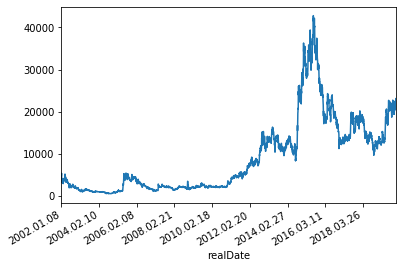

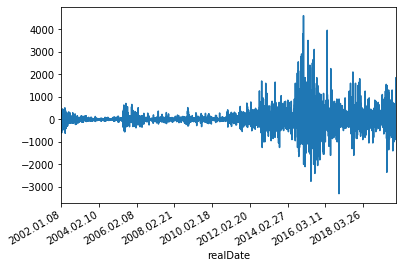

            Adj_Close  Adj_Won    Open    High     Low    Volume
realDate                                                        
2002.01.08     5000.0      0.0  5000.0  5000.0  5000.0  174230.0
2002.01.09     5400.0    400.0  5050.0  5550.0  4820.0  825422.0
2002.01.10     4800.0   -600.0  5400.0  5430.0  4760.0  268335.0
2002.01.11     4230.0   -570.0  4500.0  4850.0  4230.0  166838.0
2002.01.14     3900.0   -330.0  3820.0  4100.0  3800.0  265028.0


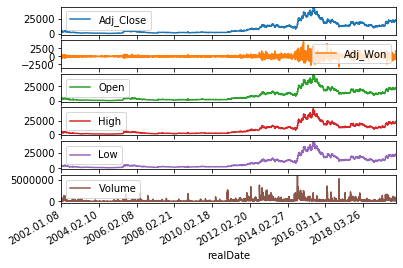

In [2]:

finance_data = pd.read_csv('finance.csv')
print(finance_data.dtypes)
print(finance_data.head())

uni_data = finance_data['Adj_Close']
uni_data.index = finance_data['realDate']
uni_data.plot(subplots=True)
plt.show()

wonUpDown_data = finance_data['Adj_Won']
wonUpDown_data.index = finance_data['realDate']
wonUpDown_data.plot(subplots=True)
plt.show()

fin_real_date = finance_data.pop('realDate')

data_len = len(finance_data)
fn_date = finance_data.pop('Date')

finance_df = finance_data
finance_df.index = fin_real_date
print(finance_df.head())

finance_df.plot(subplots=True)
plt.show()

print("="*200)

In [3]:

BATCH_SIZE = 100
BUFFER_SIZE = 1000
EVALUATION_INTERVAL = 200
EPOCHS = 100
history_size = 20
target_size = 1
STEP = 1
TRAIN_SPLIT = 3000

dataset = finance_df.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset)
print("="*200)

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, history_size,
                                                 target_size, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, history_size,
                                             target_size, STEP)


print('x_train_multi past history : {}'.format(x_train_multi.shape))
print('\n y_train_multi Target predict : {}'.format(y_train_multi.shape))
print('x_val_multi past history : {}'.format(x_val_multi.shape))
print('\n y_val_multi Target predict : {}'.format(y_val_multi.shape))

[[-0.44264112 -0.01825455 -0.44335354 -0.45716381 -0.42846118 -0.08655171]
 [-0.39766361  0.99816807 -0.43773194 -0.39677601 -0.44919629  1.77147933]
 [-0.46512988 -1.54288849 -0.39838072 -0.40995153 -0.456108    0.1819559 ]
 ...
 [ 1.55885819 -0.90762435  1.60290973  1.59602126  1.58169308  0.66764354]
 [ 1.58134695  0.48995676  1.55793691  1.56857227  1.57593333  0.54024758]
 [ 1.54761382 -0.78057152  1.59166652  1.66189886  1.61049185  1.53993306]]
x_train_multi past history : (2980, 20, 6)

 y_train_multi Target predict : (2980, 1)
x_val_multi past history : (1423, 20, 6)

 y_val_multi Target predict : (1423, 1)


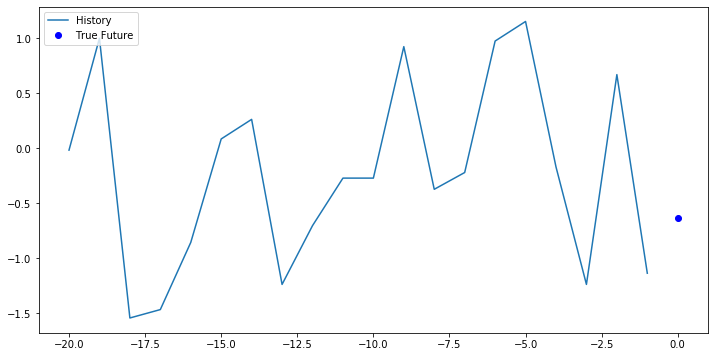

In [4]:

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [5]:

def kcp_Finance_RNNModel():

    kcp_fn_model = tf.keras.models.Sequential()
    kcp_fn_model.add(tf.keras.layers.GRU(64, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
    kcp_fn_model.add(tf.keras.layers.GRU(32, activation='tanh', return_sequences=True))
    kcp_fn_model.add(tf.keras.layers.SimpleRNN(128))
    kcp_fn_model.add(tf.keras.layers.Dropout(0.4))
    kcp_fn_model.add(tf.keras.layers.Dense(64, kernel_initializer='orthogonal'))
    kcp_fn_model.add(tf.keras.layers.Dropout(0.2))
    kcp_fn_model.add(tf.keras.layers.Dense(32, activation='relu'))
    kcp_fn_model.add(tf.keras.layers.Dense(1))
    kcp_fn_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

    kcp_fn_model.summary()
    tf.keras.utils.plot_model(kcp_fn_model, 'kcp_finance_RNNModel.png')
    tf.keras.utils.plot_model(kcp_fn_model, 'kcp_finance_RNNModel_with_shape_info.png', show_shapes=True)

    return kcp_fn_model


kcp_model = kcp_Finance_RNNModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 64)            13824     
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 32)            9408      
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               20608     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [ ]:

for x, y in val_data_multi.take(1):
    print(kcp_model.predict(x).shape)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

multi_step_history = kcp_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[tensorboard_callback])


kcp_model.save('kcp_finance_model.h5', save_format='h5')

plot_train_history(multi_step_history, 'KCP Finance Training and validation loss')

for x, y in val_data_multi.take(5):
    multi_step_plot(x[0], y[0], kcp_model.predict(x)[0])

(100, 1)
Train for 200 steps, validate for 50 steps
Epoch 1/100
200/200 [==============================] - 12s 60ms/step - loss: 0.1709 - val_loss: 0.5377
Epoch 2/100
200/200 [==============================] - 8s 39ms/step - loss: 0.0956 - val_loss: 0.4599
Epoch 3/100
200/200 [==============================] - 8s 39ms/step - loss: 0.0817 - val_loss: 0.4389
Epoch 4/100
200/200 [==============================] - 8s 38ms/step - loss: 0.0713 - val_loss: 0.5438
Epoch 5/100
200/200 [==============================] - 8s 38ms/step - loss: 0.0659 - val_loss: 0.4636
Epoch 6/100
200/200 [==============================] - 8s 38ms/step - loss: 0.0588 - val_loss: 0.5504
Epoch 7/100
200/200 [==============================] - 8s 38ms/step - loss: 0.0565 - val_loss: 0.6208
Epoch 8/100
200/200 [==============================] - 8s 38ms/step - loss: 0.0532 - val_loss: 0.6693
Epoch 9/100
200/200 [==============================] - 8s 38ms/step - loss: 0.0514 - val_loss: 0.7438
Epoch 10/100
200/200 [=======